# Projeto #3 - Meu primeiro projeto de IA

Antes de começar, leia as [Instruções](https://github.com/thvmm/pos-ds-ia/blob/master/projeto_3/README.md) e os [Critérios de Avaliação](https://github.com/thvmm/pos-ds-ia/blob/master/projeto_3/README.md).


### 1) **(5%)** Qual a base escolhida e qual seu interesse nela (podem ser mais de uma)? Descrição básica do conjunto de dados escolhido pelo aluno (1 parágrafo).

*Indique o link da base no Kaggle e explique em um parágrafo curto por que essa base é interessante para você. Quais são as características básicas da base?*

Ex: Estou trabalhando com o histório de vendas de um varejo e uma outra base do mesmo varejista das suas campanhas de marketing realizadas em veiculos de comunicação.

Base escolhida: Vôos no Brasil

Usei como base esse dataset do Kaggle: https://www.kaggle.com/ramirobentes/flights-in-brazil?select=BrFlights2.csv
Mas como ele só tem dados de 2016 e 2017 e eu queria dados mais recentes, busquei direto na fonte que foi utilizada para construi-lo, que foi o site da ANAC, na parte de dados e estatística, histórico de vôos. https://www.anac.gov.br/assuntos/dados-e-estatisticas/historico-de-voos

 Dessa página busquei os seguintes datasets:
 - dataset dos VRAs (vôo regular ativo) de todos os meses dos anos que serão utilizados na análise (2018, 2019 e 2020 até junho)
 - dataset com os nomes e localidades dos aeroportos
 - dataset com os nomes das CIAS aéreas

Depois disso foi necessário obter a descrição das justificativas para cenários de atraso, alteração, cancelamento e antecipação dos voos.
 Esses dados consegui encontrar nesse PDF (https://www.anac.gov.br/assuntos/legislacao/legislacao-1/iac-e-is/iac/iac-1504/@@display-file/arquivo_norma/IAC1504.pdf) 
 disponibilizado pela ANAC (páginas 12 a 14)
 Criei manualmente um CSV contendo o código, a descrição e a categoria de cada justificativa para fazer o merge com o data_set principal.

Motivação: Como gosto muito de viajar, foi algo que achei interessante estudar. 
 A ideia é fazer uma análise de quantidade de voos atrasados, executados e cancelados no Brasil.
 E também fazer um comparativo dos últimos 2 anos com os primeiros meses de 2020, para analisar o impacto 
 que o coronavírus causou nos vôos no Brasil, tanto domésticos como internacionais.


### 2) **(5%)** Que tipo de problema podemos solucionar com ela? Liste ao menos 3 hipóteses sobre seus dados, caso sua base seja muito restrita converse com os professores antes de seguir.
- Quais são suas hipoteses sobre os dados? O que vc espera descobrir com esse estudo?


1) Quais as Cias aéreas que mais operam voos no Brasil?
2) Qual a Cia aérea mais pontual e qual a mais atrasada?
3) Quais os principais motivos de atrasos nos vôos internacionais e domésticos?
4) A época do ano tem relação com a quantidade de vôos atrasados? Ex: Férias, meses com feriados, etc
5) A pandemia teve um grande impacto na quantidade de vôos operados no primeiro semestre de 2020?
6) Qual os estados brasileiros de onde mais saem vôos domésticos?
7) Quais os países que mais recebem vôos do Brasil? 


### 3) **(20%)** Preparação de dados

Hora de deixar a base perfeita para se trabalhar. Limpe os dados, integre com outras fontes e transforme-o para ficar pronto para se trabalhar! No fim, mostre um antes e depois de seu dataframe.

In [1]:
#pip install pycountry
#conda install geopandas
#pip install descartes
#conda install scikit-learn=0.23.2
#pip install xgboost


import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import geopandas as gpd
import plotly.express as px
from datetime import datetime, date, time, timezone
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pycountry


from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score


from sklearn.linear_model import Lasso,LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,RandomForestClassifier
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

figsize = (10, 7)
matplotlib.rcParams['figure.figsize'] = figsize

In [2]:
# Fazendo a importação dos datasets dos VRAs
# O mês de julho de 2019 foi preenchido utilizando tab como espaçamento, e não ";".

dir_datasets = 'datasets/'

 

li = []
for mes in range(12):
    df_2018 = pd.read_csv(dir_datasets + str(mes+1) + '_2018.csv', sep=';', dtype=str)
    df_2018['mes'] = mes + 1
    df_2018['ano'] = 2018
    li.append(df_2018)
    
    if mes < 6:
        df_2020 = pd.read_csv(dir_datasets + str(mes+1) + '_2020.csv', sep=';', dtype=str)
        df_2020['mes'] = mes + 1
        df_2020['ano'] = 2020
        li.append(df_2020)
    
    if mes != 6:
        df_2019 = pd.read_csv(dir_datasets + str(mes+1) + '_2019.csv', sep=';', dtype=str)
        
    else:
        df_2019 = pd.read_csv(dir_datasets + '/7_2019.csv', sep='\t', dtype=str)
        
    df_2019['mes'] = mes + 1
    df_2019['ano'] = 2019
    li.append(df_2019)
   
df_voos = pd.concat(li, axis=0, ignore_index=True)
df_voos.head()

ICAO Empresa Aerea Numero Voo Codigo Autorizacao (DI) Codigo Tipo Linha  \
0                AAL       1265                       0                 I   
1                AAL       1265                       0                 I   
2                AAL       1265                       0                 I   
3                AAL       1265                       0                 I   
4                AAL       1265                       0                 I   

  ICAO Aerodromo Origem ICAO Aerodromo Destino  Partida Prevista  \
0                  KMIA                   SBEG  01/01/2018 20:30   
1                  KMIA                   SBEG  02/01/2018 20:30   
2                  KMIA                   SBEG  03/01/2018 20:30   
3                  KMIA                   SBEG  04/01/2018 20:30   
4                  KMIA                   SBEG  05/01/2018 20:30   

       Partida Real  Chegada Prevista      Chegada Real Situacao Voo  \
0  01/01/2018 20:30  02/01/2018 01:53  02/01/2018 01:53    REALIZADO   
1  02/01/2018 20:30  03/01/2018 01:53  03/01/2018 01:53    REALIZADO   
2  03/01/2018 20:30  04/01/2018 01:53  04/01/2018 01:53    REALIZADO   
3  04/01/2018 20:30  05/01/2018 01:53  05/01/2018 01:53    REALIZADO   
4  05/01/2018 20:30  06/01/2018 01:53  06/01/2018 01:53    REALIZADO   

  Codigo Justificativa  mes   ano  
0                  NaN    1  2018  
1                  NaN    1  2018  
2                  NaN    1  2018  
3                  NaN    1  2018  
4                  NaN    1  2018

In [3]:
df_voos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2286927 entries, 0 to 2286926
Data columns (total 14 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   ICAO Empresa Aerea       object
 1   Numero Voo               object
 2   Codigo Autorizacao (DI)  object
 3   Codigo Tipo Linha        object
 4   ICAO Aerodromo Origem    object
 5   ICAO Aerodromo Destino   object
 6   Partida Prevista         object
 7   Partida Real             object
 8   Chegada Prevista         object
 9   Chegada Real             object
 10  Situacao Voo             object
 11  Codigo Justificativa     object
 12  mes                      int64 
 13  ano                      int64 
dtypes: int64(2), object(12)
memory usage: 244.3+ MB


In [4]:
# Importando o DF de aeroportos

df_aeroportos = pd.read_excel(dir_datasets + 'aerodromos.xls')
df_aeroportos.head()

Sigla OACI                                      Descrição  \
0       1AON                            OUROLANDIA DO NORTE   
1       2NHT                             HOTEL TRANSAMÉRICA   
2       6ASO                                        SORRISO   
3       CYMX         MONTREAL-MIRABEL INTERNATIONAL AIRPORT   
4       CYQB  QUEBEC CITY JEAN LESAGE INTERNATIONAL AIRPORT   

                    Cidade   UF    País        Continente  
0      OURILANDIA DO NORTE   PA  BRASIL    AMERICA DO SUL  
1                     UNA    BA  BRASIL    AMERICA DO SUL  
2                  SORRISO   MT  BRASIL    AMERICA DO SUL  
3                  MIRABEL  NaN  CANADA  AMERICA DO NORTE  
4  QUEBEC JEAN LESAGE INTL  NaN  CANADA  AMERICA DO NORTE

In [5]:
# Fazendo o merge das coluna do data frame de aeroportos no DF Principal.
# Como estamos utilizando colunas string para o merge, vamos garantir que só existem valores upper_case em ambos nos dfs.

df_voos['ICAO Aerodromo Origem'] = df_voos['ICAO Aerodromo Origem'].str.upper()
df_voos['ICAO Aerodromo Destino'] = df_voos['ICAO Aerodromo Destino'].str.upper()

df_aeroportos['Sigla OACI'] = df_aeroportos['Sigla OACI'].str.upper()

df_voos = pd.merge(df_voos, df_aeroportos, how="left", left_on="ICAO Aerodromo Origem", right_on="Sigla OACI")
df_voos = pd.merge(df_voos, df_aeroportos, how="left", left_on="ICAO Aerodromo Destino", right_on="Sigla OACI")

#removendo colunas que não serão utilizadas
df_voos.drop(['Codigo Autorizacao (DI)', 'Codigo Tipo Linha', 'ICAO Aerodromo Origem','ICAO Aerodromo Destino' ], axis=1, inplace=True)


In [6]:
# Importando e fazendo merge dos dados de cias aéreas

df_cias = pd.read_excel(dir_datasets + 'empresas_aereas.xls')

df_cias['Sigla OACI'] = df_cias['Sigla OACI'].str.upper()
df_voos['ICAO Empresa Aerea'] = df_voos['ICAO Empresa Aerea'].str.upper()

df_voos = pd.merge(df_voos, df_cias, how="left", left_on='ICAO Empresa Aerea', right_on="Sigla OACI")

# removendo coluna não utilizada
df_voos.drop(['ICAO Empresa Aerea' ], axis=1, inplace=True)


In [7]:
# Renomeando as colunas
df_voos.columns = ['nro_voo', 'partida_prev', 'partida_real', 'chegada_prev',
                     'chegada_real', 'situacao_voo', 'cod_justificativa', 'mes', 'ano', 'cod_aeroporto_origem', 
                      'nome_aeroporto_origem', 'cidade_origem', 'uf_origem', 'pais_origem', 'continente_origem',
                      'cod_aeroporto_destino', 'nome_aeroporto_destino', 'cidade_destino', 'uf_destino', 'pais_destino', 'continente_destino',
                      'cod_cia', 'nome_cia', 'origem_cia']

In [8]:
#Importando o dataframe de justificativas
df_justificativas = pd.read_csv(dir_datasets + 'justificativas.csv', sep=',')

# Fazendo o merge das justificativas para completar o dataset. 
# Antes será necessário alterar os códigos no df_voos para upper case para que o merge ocorra corretamente.
df_voos['cod_justificativa'] = df_voos['cod_justificativa'].str.upper()
df_voos = pd.merge(df_voos, df_justificativas, how="left", left_on="cod_justificativa", right_on="cod_justificativa")


In [9]:
df_voos.describe(include = "all")

nro_voo partida_prev   partida_real      chegada_prev   chegada_real  \
count   2286635      2273828        2212393           2272379        2212393   
unique     7808       314670         890356            324099         913702   
top         248         SBGR  NAO INFORMADO  06/12/2019 20:25  NAO INFORMADO   
freq       2863         1684             46                29             46   
mean        NaN          NaN            NaN               NaN            NaN   
std         NaN          NaN            NaN               NaN            NaN   
min         NaN          NaN            NaN               NaN            NaN   
25%         NaN          NaN            NaN               NaN            NaN   
50%         NaN          NaN            NaN               NaN            NaN   
75%         NaN          NaN            NaN               NaN            NaN   
max         NaN          NaN            NaN               NaN            NaN   

       situacao_voo cod_justificativa           mes           ano  \
count       2285478            672423  2.286927e+06  2.286927e+06   
unique         6359                50           NaN           NaN   
top       REALIZADO                AT           NaN           NaN   
freq        2204760            149092           NaN           NaN   
mean            NaN               NaN  5.941498e+00  2.018665e+03   
std             NaN               NaN  3.591238e+00  6.769204e-01   
min             NaN               NaN  1.000000e+00  2.018000e+03   
25%             NaN               NaN  3.000000e+00  2.018000e+03   
50%             NaN               NaN  6.000000e+00  2.019000e+03   
75%             NaN               NaN  9.000000e+00  2.019000e+03   
max             NaN               NaN  1.200000e+01  2.020000e+03   

       cod_aeroporto_origem  ...                       nome_aeroporto_destino  \
count               2267106  ...                                      2275563   
unique                  346  ...                                          354   
top                    SBGR  ...  GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO   
freq                 318416  ...                                       320719   
mean                    NaN  ...                                          NaN   
std                     NaN  ...                                          NaN   
min                     NaN  ...                                          NaN   
25%                     NaN  ...                                          NaN   
50%                     NaN  ...                                          NaN   
75%                     NaN  ...                                          NaN   
max                     NaN  ...                                          NaN   

       cidade_destino uf_destino pais_destino continente_destino  cod_cia  \
count         2273285    2063912      2275563            2275563  2259533   
unique            323         28           68                  6       64   
top         GUARULHOS         SP       BRASIL     AMERICA DO SUL      AZU   
freq           320719     696214      2062459            2170672   665044   
mean              NaN        NaN          NaN                NaN      NaN   
std               NaN        NaN          NaN                NaN      NaN   
min               NaN        NaN          NaN                NaN      NaN   
25%               NaN        NaN          NaN                NaN      NaN   
50%               NaN        NaN          NaN                NaN      NaN   
75%               NaN        NaN          NaN                NaN      NaN   
max               NaN        NaN          NaN                NaN      NaN   

       nome_cia  origem_cia                    descricao_justificativa  \
count   2259533     2256814                                     663935   
unique       63           3                                         46   
top        AZUL  BRASILEIRA  LIBERAÇÃO SERV. TRAFEGO AÉREO/ANTECIPAÇÃO   
freq     665044     2013

In [10]:
# Executando o describe para ter uma visão estatística geral dos dados, percebi que:
# - O vôo mais frequente é o de nro 248
# - A Cia aérea mais frequente é a Azul
# - O destino mais frequente é SP / Brasil

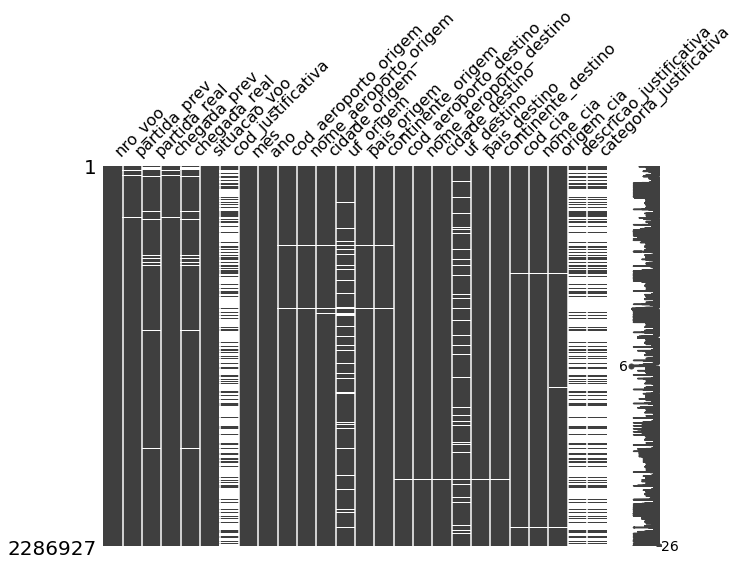

In [11]:
# Visualizar dados faltantes

msno.matrix(df_voos, figsize=figsize)

In [12]:
### Através da visualização acima podemos perceber que:

# 1) As colunas de nro do vôo, situação do vôo, partida e chegada previstas, dados de aeroporto de origem (exceto UF) 
# estão praticamente com 100% de preenchimento.
# 2) Algumas poucas linhas relacionadas ao aeroporto de origem ou destino não estão preenchidas.
# 3) As colunas de justificativa, que informam o motivo pelo qual um vôo não ocorreu conforme previsto tem muitas linhas vazias.
# O que significa que a maior parte dos voos ocorreu dentro do planejado.
# 4) Alguns dados das colunas partida_real e chegada_real também estão vazios. Provavelmente isso ocorre 
# nos casos em que a situação do vôo é CANCELADA.
# 5) As colunas uf_origem e uf_destino possuem alguns dados vazios, o que é compreensível já que temos também vôos de e para fora do Brasil.


# Agora vamos analisar as quantidades de valores vazios

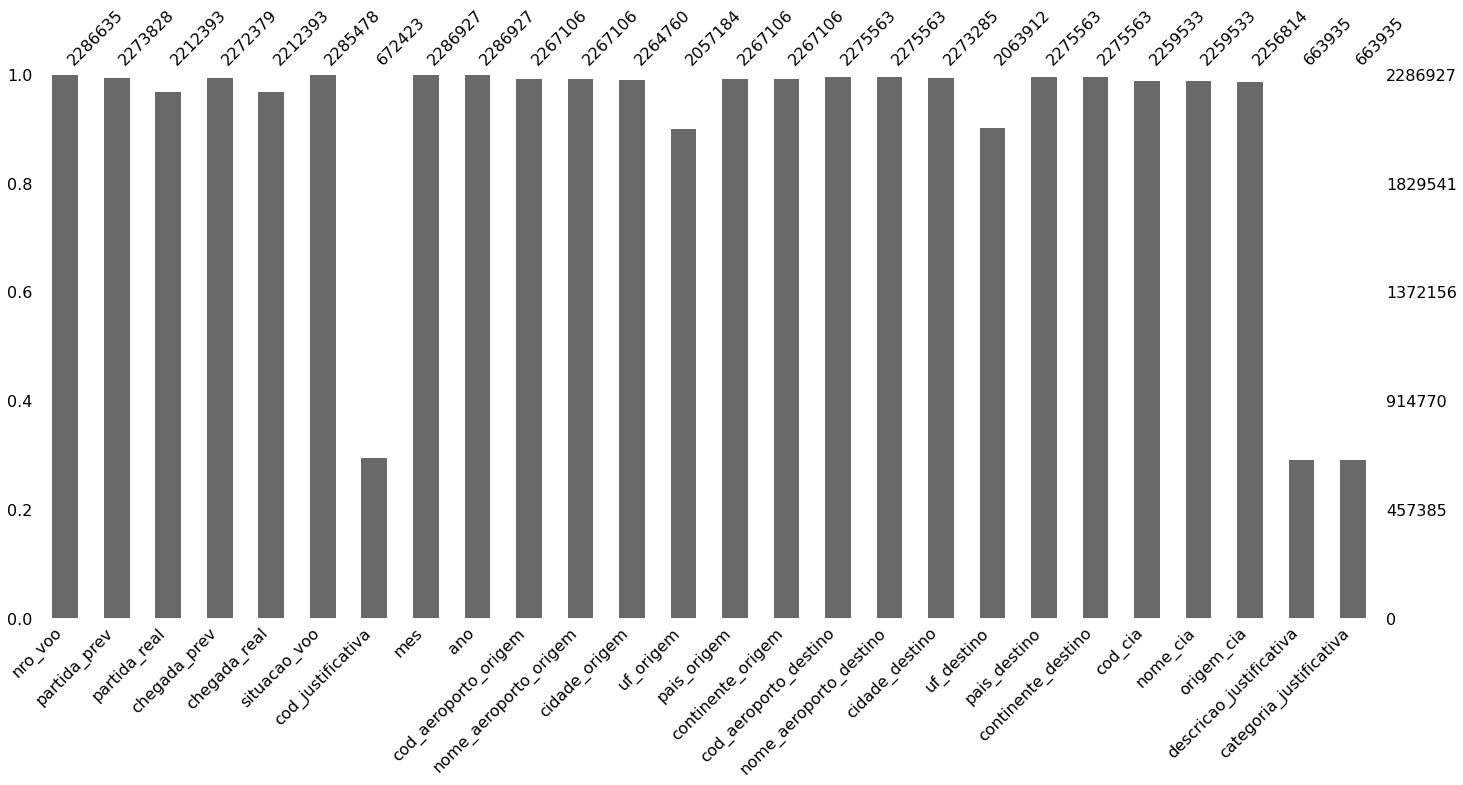

In [13]:
msno.bar(df_voos)

In [14]:
# Apesar de no plot anterior percebermos que praticamente todas as linhas possuiam o codigo do aeroporto de origem preenchidas,
# olhando para os números vemos que aproximadamente 11 mil linhas não possuem esse valor.

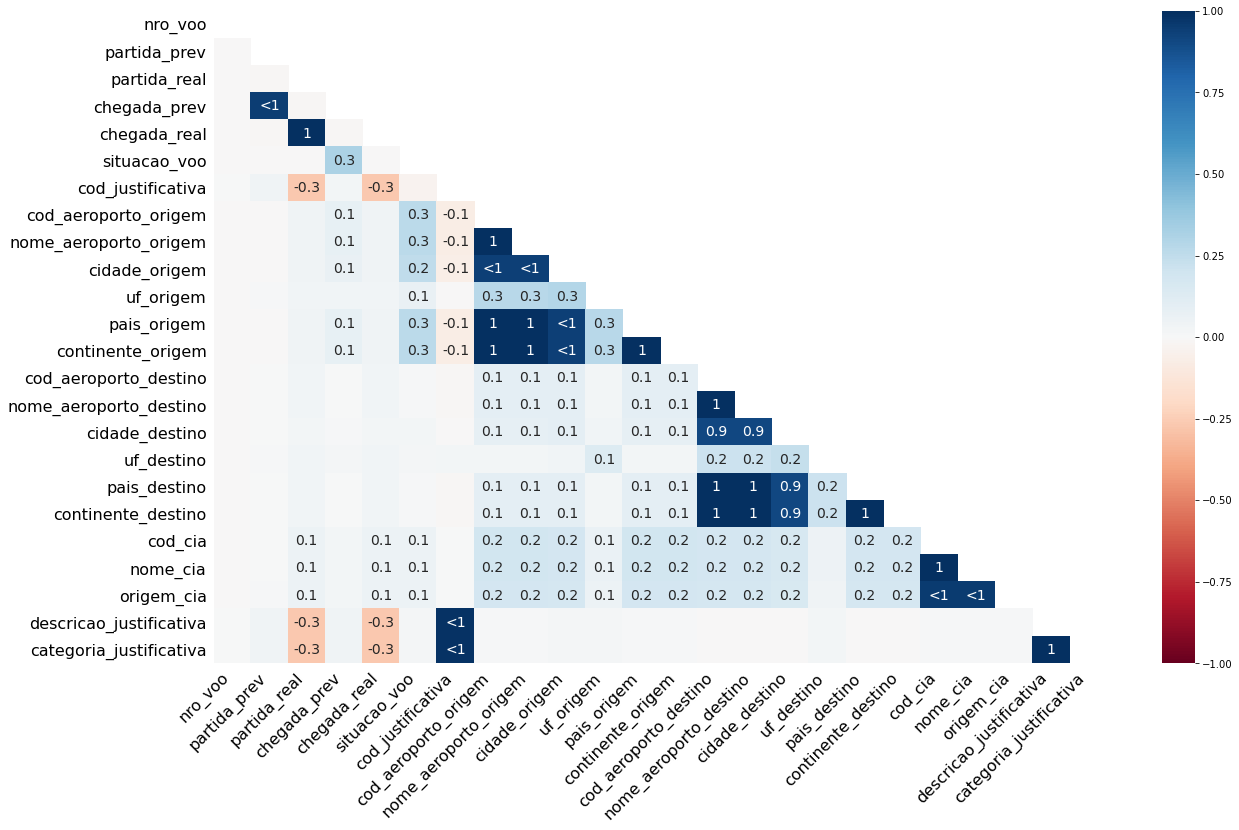

In [15]:
msno.heatmap(df_voos)

In [16]:
# Observando o heatmap conseguimos perceber uma certa correlação entre as colunas descricao_justificativa e categoria_justificativa
# com as colunas partida_real e chegada_real. Esse cenário faz sentido, pois a justificativa é preenchida, entre outros cenários
# quando um vôo é cancelado, ou seja, não há partida nem chegada real.

In [17]:
# Limpando os dados

# Não serão removidos todos os dados nulos, pois na maior parte dos casos onde eles não existem não significa que há um problema,
# e sim que é uma característica real do negócio.

# Iremos remover as linhas nos cenários em que:

# - a partida prevista não foi informada
# - a chegada prevista não foi informada
# - o código do aeroporto origem não foi informado
# - o código do aeroporto destino não foi informado
# - não há numero do voo

qtde_anterior = len(df_voos.index)

sem_partida_prevista = pd.notnull(df_voos["partida_prev"]) 
df_voos = df_voos[sem_partida_prevista]

sem_chegada_prevista = pd.notnull(df_voos["chegada_prev"]) 
df_voos = df_voos[sem_chegada_prevista]

sem_origem = pd.notnull(df_voos["cod_aeroporto_origem"]) 
df_voos = df_voos[sem_origem]

sem_destino = pd.notnull(df_voos["cod_aeroporto_destino"]) 
df_voos = df_voos[sem_destino]

sem_nrovoo = pd.notnull(df_voos["nro_voo"]) 
df_voos = df_voos[sem_nrovoo]

qtde_depois = len(df_voos.index)



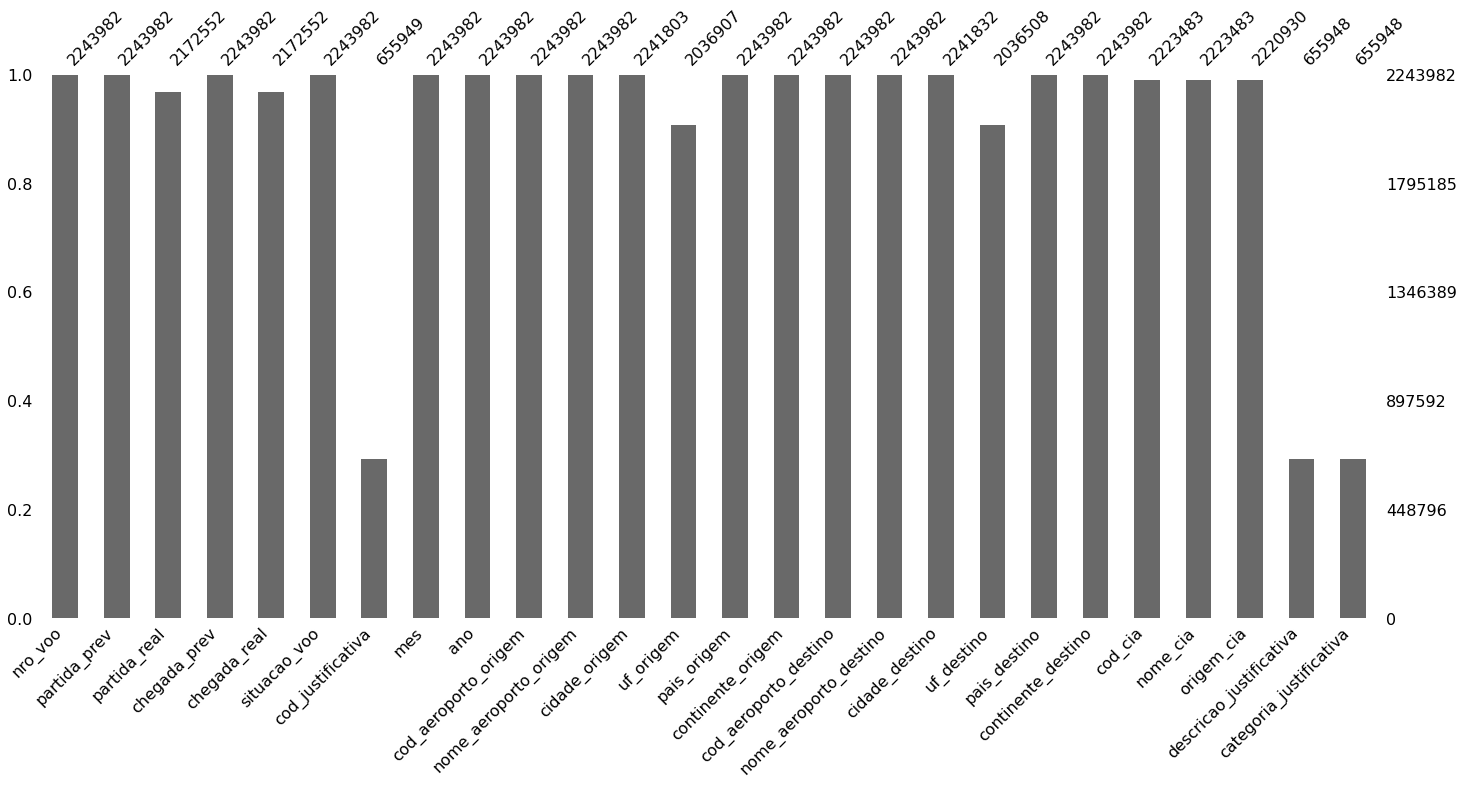

In [18]:
# Olhando novamente para as quantidades...

msno.bar(df_voos)

In [19]:
# Comparativo da quantidade de dados após a limpeza 
# Percebemos que ainda temos praticamente todo o nosso dataset para trabalhar, menos de 2% da base foi removida. 

print('Quantidade de linhas anterior: ', qtde_anterior)
print('Quantidade de linhas após as remoções: ', qtde_depois)
print('Total de linhas removidas: ', qtde_anterior - qtde_depois)
print('Percentual de linhas que restaram: ', qtde_depois / qtde_anterior * 100)

Quantidade de linhas anterior:  2286927
Quantidade de linhas após as remoções:  2243982
Total de linhas removidas:  42945
Percentual de linhas que restaram:  98.1221525654295


In [20]:
# Vamos ainda inserir uma coluna que diz se o vôo é domestico ou internacional
conditions = [
    (df_voos.pais_origem == 'BRASIL') & (df_voos.pais_destino == 'BRASIL'),
    (df_voos.pais_origem != 'BRASIL') | (df_voos.pais_destino != 'BRASIL')
]

choices = ['Doméstico', 'Internacional']

df_voos['tipo_voo'] = np.select(conditions, choices, default=np.nan)

In [21]:
# Vamos criar uma coluna para categorizar os voos REALIZADOS de acordo com a sua pontualidade, criando as categorias:

# Vôo antecipado ou efetuado em até 5 minutos após o horario previsto - PONTUAL
# Vôo com atraso entre 5 e 30 minutos - ATRASO_MINIMO
# Vôo com atraso entre 30 min e 1 hora - ATRASO_MEDIO
# Vôo com 1h até 4h de atraso - ATRASO_ALTO - Pode gerar muitos problemas para o passageiro"
# Vôo com mais de 4h de atraso - REEMBOLSAVEL - A CIA aérea já é obrigada a reembolsar"


def define_categoria_horario(item):
    formato = '%d/%m/%Y %H:%M'
    
    real_nao_nulo = pd.notna(item['partida_real'])
    prev_nao_nulo = pd.notna(item['partida_prev'])
    real_informado = item['partida_real'] != 'NAO INFORMADO'
    prev_informado = item['partida_prev'] != 'NAO INFORMADO'

    
    if (real_nao_nulo & prev_nao_nulo & real_informado & prev_informado):
    
        dif = datetime.strptime(item['partida_real'], formato) - datetime.strptime(item['partida_prev'], formato)
        dif_em_segundos = dif.total_seconds()
        
        if (dif_em_segundos <= 300.0):
            return 'PONTUAL'
        elif dif_em_segundos >= 300.0  and dif_em_segundos <= 1800.0:
            return 'ATRASO_MINIMO'
        elif dif_em_segundos > 1800.0 and dif_em_segundos <= 3600.0:
            return 'ATRASO_MEDIO'
        elif dif_em_segundos > 3600.0 and dif_em_segundos <= 14400.0:
            return 'ATRASO_ALTO'
        elif dif_em_segundos > 14400.0:
            return 'REEMBOLSAVEL'
    
    return 'VOO_CANCELADO'

In [22]:
df_voos['categoria_horario'] = df_voos.apply(define_categoria_horario, axis=1)
df_voos.head()

nro_voo      partida_prev      partida_real      chegada_prev  \
0    1265  01/01/2018 20:30  01/01/2018 20:30  02/01/2018 01:53   
1    1265  02/01/2018 20:30  02/01/2018 20:30  03/01/2018 01:53   
2    1265  03/01/2018 20:30  03/01/2018 20:30  04/01/2018 01:53   
3    1265  04/01/2018 20:30  04/01/2018 20:30  05/01/2018 01:53   
4    1265  05/01/2018 20:30  05/01/2018 20:30  06/01/2018 01:53   

       chegada_real situacao_voo cod_justificativa  mes   ano  \
0  02/01/2018 01:53    REALIZADO               NaN    1  2018   
1  03/01/2018 01:53    REALIZADO               NaN    1  2018   
2  04/01/2018 01:53    REALIZADO               NaN    1  2018   
3  05/01/2018 01:53    REALIZADO               NaN    1  2018   
4  06/01/2018 01:53    REALIZADO               NaN    1  2018   

  cod_aeroporto_origem  ... uf_destino pais_destino continente_destino  \
0                 KMIA  ...         AM       BRASIL     AMERICA DO SUL   
1                 KMIA  ...         AM       BRASIL     AMERICA DO SUL   
2                 KMIA  ...         AM       BRASIL     AMERICA DO SUL   
3                 KMIA  ...         AM       BRASIL     AMERICA DO SUL   
4                 KMIA  ...         AM       BRASIL     AMERICA DO SUL   

  cod_cia               nome_cia   origem_cia descricao_justificativa  \
0     AAL  AMERICAN AIRLINES INC  ESTRANGEIRA                     NaN   
1     AAL  AMERICAN AIRLINES INC  ESTRANGEIRA                     NaN   
2     AAL  AMERICAN AIRLINES INC  ESTRANGEIRA                     NaN   
3     AAL  AMERICAN AIRLINES INC  ESTRANGEIRA                     NaN   
4     AAL  AMERICAN AIRLINES INC  ESTRANGEIRA                     NaN   

  categoria_justificativa       tipo_voo categoria_horario  
0                     NaN  Internacional           PONTUAL  
1                     NaN  Internacional           PONTUAL  
2                     NaN  Internacional           PONTUAL  
3                     NaN  Internacional           PONTUAL  
4                     NaN  Internacional           PONTUAL  

[5 rows x 28 columns]

### 4) **(30%)** Análise

Com seu dado pronto, é hora de fazer a parte mais legal: investigar e responder nossas hipoteses. Elas se confirmam? Em quais cenários? Existe alguma forma de perceber isso no mundo real? Dica: Abuse das técnicas de visualização.

Ex: Ainda no contexto dos exemplos do item 2). Ao investigar a hipotese relacionada ao padrão de compra, percebi que em todos os meses existia uma diferença entre dia util e final de semana. Porém notei que Fevereiro possui um comportamento diferente, o que poderia explicar? Talvez o carnaval e seus feriados.

Ex2: Talvez eu descubra que alguns finais de semana possuam um comportamento diferente dos dias de semana e outros não. Por que não são todos? Nessa investigação você pode acabar descobrindo que os finais de semana que são diferentes, coincidem no fato de serem os primeiros dias utéis, o que pode remeter ao fato de boa parte das empresas realizarem pagamentos nessa parte do mês.

In [23]:
# Alguns gráficos de pizza para analisar de forma geral a base inteira

df_tipo = df_voos.groupby(["tipo_voo"]).size().reset_index(name='qtde')
df_uf_origem = df_voos.groupby(["uf_origem"]).size().reset_index(name='qtde')
df_situacao = df_voos.groupby(["situacao_voo"]).size().reset_index(name='qtde')
df_origem_cia = df_voos.groupby(["origem_cia"]).size().reset_index(name='qtde')
df_ano = df_voos.groupby(["ano"]).size().reset_index(name='qtde')

fig = px.pie(df_ano, values='qtde', names='ano', title='Quantidade de vôos por ano')
fig.show()


In [24]:
fig = px.pie(df_tipo, values='qtde', names='tipo_voo', title='Quantidade de vôos por tipo')
fig.show()

In [25]:
fig = px.pie(df_origem_cia, values='qtde', names='origem_cia', title='Quantidade de vôos por origem da CIA Aérea')
fig.show()

In [26]:
fig = px.pie(df_situacao, values='qtde', names='situacao_voo', title='Quantidade de vôos por situação do vôo')
fig.show()

In [27]:
fig = px.pie(df_uf_origem, values='qtde', names='uf_origem', title='Quantidade de vôos por estado brasileiro de origem')
fig.show()

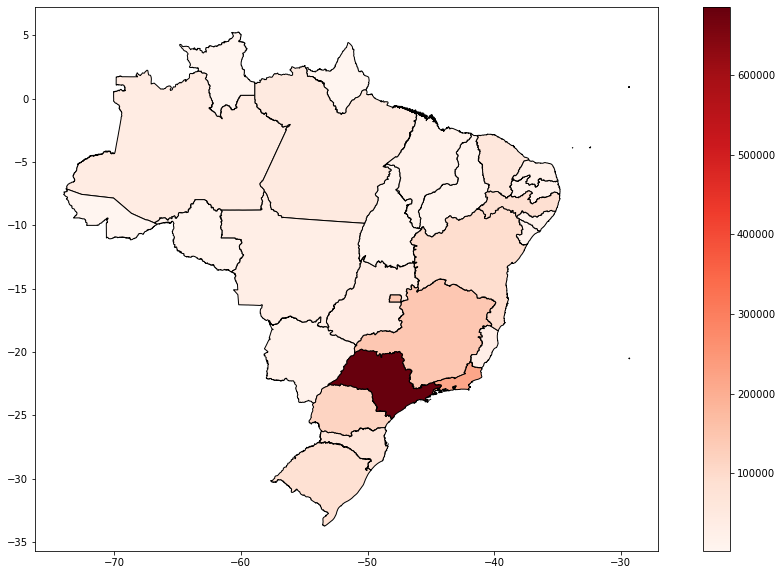

In [28]:
# No último gráfico, vemos que SP é o estado brasileiro de onde mais saem vôos no Brasil.
# Vamos plotar essa mesma informação utilizando o mapa do Brasil.

from descartes import PolygonPatch

#Dos vôos domésicos, qual o estado tem a maior parte da origem de voos
INFOS_UFS = gpd.read_file('bcim_2016_21_11_2018.gpkg', layer='lim_unidade_federacao_a')

df_uf_origem = df_voos.groupby(["uf_origem"]).size().reset_index(name='qtde')
df_uf_origem.sort_values(by=['qtde'], inplace=True, ascending=False)

mapa_brasil_origem = INFOS_UFS.merge(df_uf_origem, how="left", left_on="sigla", right_on="uf_origem")

mapa_brasil_origem.plot(column='qtde',
                cmap='Reds',
                figsize=(16,10),
                legend=True,
                edgecolor='Black')

In [29]:
# Separando os voos domesticos e internacionais realizados para facilitar as análises

df_internacionais = df_voos[(df_voos.pais_destino != 'BRASIL') & (df_voos.situacao_voo == 'REALIZADO')]
df_domesticos = df_voos[(df_voos.pais_origem == 'BRASIL') & (df_voos.pais_destino == 'BRASIL') & (df_voos.situacao_voo == 'REALIZADO')]


In [30]:
# Quantidade de vôos por ano

In [31]:
df_domesticos_qtde = df_domesticos.groupby(["mes", "ano"]).size().reset_index(name='qtde')
df_domesticos_qtde.sort_values(by=['mes'], inplace=True)

fig = px.line(df_domesticos_qtde, x="mes", y="qtde", color='ano', title='Qtde de voos domésticos por mês de 2018 e 2020')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

fig.show()

In [32]:
df_internacionais = df_voos[((df_voos.pais_origem != 'BRASIL') | (df_voos.pais_destino != 'BRASIL')) & (df_voos.situacao_voo == 'REALIZADO')]

df_internacionais_qtde = df_internacionais.groupby(["mes", "ano"]).size().reset_index(name='qtde')
df_internacionais_qtde.sort_values(by=['mes'], inplace=True)

fig = px.line(df_internacionais_qtde, x="mes", y="qtde", 
              color='ano', title='Qtde de voos com origem ou destino fora do Brasil ' +
              'por mês de 2018 a 2020')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

fig.show()

In [33]:
# Agora uma análise sobre as COMPANHIAS AÉREAS

In [34]:
# Quais as CIAS que mais operam voos no Brasil de 2018 a 2020 
df_realizados_cias_brasileiras = df_voos[(df_voos.situacao_voo == 'REALIZADO')
                        & (df_voos.origem_cia == 'BRASILEIRA')]

df_cias_qtde = df_realizados_cias_brasileiras.groupby(["nome_cia", "ano"]).size().reset_index(name='qtde')
df_cias_qtde.sort_values(by=['qtde', 'ano'], inplace=True, ascending=False)

def converteAnoParaString(item):
    return str(item['ano'])

df_cias_qtde['ano_str'] = df_cias_qtde.apply(converteAnoParaString, axis=1)

fig = px.bar(df_cias_qtde, y='qtde', x='nome_cia', 
             text='qtde', 
             color='ano_str',
             labels={'qtde':'Quantidade de vôos', 'nome_cia': 'Cia Aérea'},
             title="Quantidade de vôos operados por CIAs Aéreas brasileiras de 2018 a 2020")
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

# Ao longo dos três anos, a CIA aérea AZUL é a cia brasileira que mais opera vôos no Brasil, seguida da GOL e TAM.

In [35]:
# E entre as estrangeiras?
# Entre as CIAS aéreas estrangeiras, quais as que mais operam vôos para o Brasil?

df_realizados_cias_estrangeiras = df_voos[(df_voos.situacao_voo == 'REALIZADO')
                           & (df_voos.origem_cia == 'ESTRANGEIRA')]

df_cias_qtde = df_realizados_cias_estrangeiras.groupby(["nome_cia", "ano"]).size().reset_index(name='qtde')
df_cias_qtde.sort_values(by=['qtde', 'ano'], inplace=True, ascending=False)

df_cias_qtde['ano_str'] = df_cias_qtde.apply(converteAnoParaString, axis=1)

fig = px.bar(df_cias_qtde, x='qtde', y='nome_cia', 
             text='qtde', 
             color='ano_str',
             labels={'qtde':'Quantidade de vôos', 'nome_cia': 'Cia Aérea'},
             title="Quantidade de vôos operados por CIAS aéreas estrangeiras de 2018 a 2020",
            orientation='h')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

# Ao longo dos três anos, as CIAS aéreas estrangerias que mais operaram vôos para o Brasil foram: Aerolineas Argentinas, COPA e TAP.

In [36]:
# Cancelamentos

#voos totais da cia

df_domesticos = df_voos[(df_voos.pais_origem != 'BRASIL') 
                            & (df_voos.pais_destino == 'BRASIL')
                            & (df_voos.origem_cia == 'BRASILEIRA')]

df_voos_qtde = df_domesticos.groupby(["nome_cia", "ano"]).size().reset_index(name='qtde')

df_domesticos_cancelados = df_domesticos[(df_domesticos.situacao_voo == 'CANCELADO')]

df_categorias_qtde = df_domesticos_cancelados.groupby(["nome_cia", "ano"]).size().reset_index(name='qtde_cancelados')
df_categorias_qtde.sort_values(by=['qtde_cancelados'], inplace=True, ascending=False)

df_percentual = df_voos_qtde.merge(df_categorias_qtde, how="left", left_on=["nome_cia", "ano"], right_on=["nome_cia", "ano"])



In [37]:
    
def calcula_percentual_cancelados(item):
    return item['qtde_cancelados'] / item['qtde'] * 100

df_percentual['percent_cancelamento'] = df_percentual.apply(calcula_percentual_cancelados, axis=1)
df_percentual.sort_values(by=['percent_cancelamento'], inplace=True, ascending=False)


In [38]:
dfcanc2018 = df_percentual[df_percentual.ano == 2018]
dfcanc2019 = df_percentual[df_percentual.ano == 2019]
dfcanc2020 = df_percentual[df_percentual.ano == 2020]

fig = go.Figure(
    data=[
        go.Bar(name='2018', x=dfcanc2018['nome_cia'], y=dfcanc2018['percent_cancelamento']),
        go.Bar(name='2019', x=dfcanc2019['nome_cia'], y=dfcanc2019['percent_cancelamento']),
        go.Bar(name='2020', x=dfcanc2020['nome_cia'], y=dfcanc2020['percent_cancelamento'])
    ],
)

# Change the bar mode
fig.update_layout(barmode='group', title='Percentual de vôos cancelados por CIA aérea em 2018, 2019 e 2020')
fig.show()

In [39]:
# Atrasos

# Agora vamos ver o percentual de voos domésticos atrasados.
# Para essa análise iremos avaliar separadamente: voos de 2018 e 2019 em um gráfico, e 2020 em outro gráfico

def calcula_percentual(item):
    return item['qtde_y'] / item['qtde_x'] * 100

def plotarGraficoPercentualVoosAtrasadosPorCiaAerea(df, ano):
    df_voos_qtde = df.groupby(["nome_cia"]).size().reset_index(name='qtde')

    df_categorias_qtde = df.groupby(["nome_cia", "categoria_horario"]).size().reset_index(name='qtde')
    df_categorias_qtde.sort_values(by=['qtde'], inplace=True, ascending=False)

    df_percentual = df_voos_qtde.merge(df_categorias_qtde, how="left", left_on="nome_cia", right_on="nome_cia")
    df_percentual['percentual_por_categoria'] = df_percentual.apply(calcula_percentual, axis=1)
    df_percentual.sort_values(by=['percentual_por_categoria'], inplace=True, ascending=False)

    fig = px.bar(df_percentual, y='percentual_por_categoria', x='nome_cia', 
             text='percentual_por_categoria', 
             color='categoria_horario',
             labels={'qtde':'Quantidade de vôos', 'nome_cia': 'Cia Aérea'},
             title="Percentual de vôos por categorias de pontualidade por CIA Aérea Brasileira em " + ano)
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    fig.show()

In [40]:
df_domesticos_realizados = df_voos[(df_voos.pais_origem == 'BRASIL') 
                        & (df_voos.pais_destino == 'BRASIL') 
                        & (df_voos.situacao_voo == 'REALIZADO')
                        & (df_voos.origem_cia == 'BRASILEIRA')]


In [41]:
df_domesticos_1819 = df_domesticos_realizados[(df_domesticos_realizados.ano <= 2019)]
df_domesticos_20 = df_domesticos_realizados[(df_domesticos_realizados.ano == 2020)]

plotarGraficoPercentualVoosAtrasadosPorCiaAerea(df_domesticos_1819, '2018 e 2019')
plotarGraficoPercentualVoosAtrasadosPorCiaAerea(df_domesticos_20, '2020')

In [42]:
# Podemos associar o atraso de vôos com a época do ano? 
# OBs: vamos analisar atrasos acima de 1h
# Ex: Final de ano devido às festas e feriados, os voos ocorrem com mais atraso?


def calcula_percentual_atrasados(item):
    return item['qtde_y'] / item['qtde_x'] * 100

# ALTERAR PARA PERCENTUAL


def plotarGraficoPercentualAtrasados(df, tipo):
    df_por_mes = df.groupby(["mes", "ano"]).size().reset_index(name='qtde')

    df_atrasados = df[(df_voos.categoria_horario != 'PONTUAL') 
                                        & (df_voos.categoria_horario != 'ATRASO_MINIMO') 
                                        & (df_voos.categoria_horario != '')]
    
    df_atrasados_qtde = df_atrasados.groupby(["mes", "ano"]).size().reset_index(name='qtde')
    df_atrasados_qtde.sort_values(by=['mes'], inplace=True)


    df_percentual = df_por_mes.merge(df_atrasados_qtde, how="left", left_on=["mes", "ano"], right_on=["mes", "ano"])

    df_percentual['percentual'] = df_percentual.apply(calcula_percentual_atrasados, axis=1)

    fig = px.line(df_percentual, x="mes", 
                  y="percentual", 
                  color='ano', 
                  title='Percentual de voos ' + tipo + ' ATRASADOS por mês em 2018, 2019 e 2020')
    
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    fig.show()

In [43]:
plotarGraficoPercentualAtrasados(df_domesticos, 'domésticos')
plotarGraficoPercentualAtrasados(df_internacionais, 'internacionais')

C:\Users\kessia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [44]:
# E quais foram os principais motivos pelos quais os vôos atrasaram mais de 1 hora
# Apenas 2018 e 2019

def plotarGraficoPorDescricaoJustificativaAtraso(df, tipo):
    df_atrasados = df[(df_voos.categoria_horario != 'PONTUAL') 
                          & (df_voos.situacao_voo == 'REALIZADO') 
                          & (df_voos.categoria_horario != 'ATRASO_MEDIO') 
                          & (df_voos.categoria_horario != '')]
    df_qtde = df_atrasados.groupby(["descricao_justificativa", "ano"]).size().reset_index(name='qtde')
    df_qtde.sort_values(by=['qtde'], inplace=True, ascending=False)
    
    df_qtde['ano_str'] = df_qtde.apply(converteAnoParaString, axis=1)
    
    
    fig = px.bar(df_qtde, y='qtde', x='descricao_justificativa', 
             color='ano_str', facet_row="ano",
             title="Motivos pelos quais ocorreram atrasos acima de 1h nos vôos " + tipo + " de 2018 a 2020")
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    fig.show()


In [45]:
plotarGraficoPorDescricaoJustificativaAtraso(df_domesticos, 'domésticos')
plotarGraficoPorDescricaoJustificativaAtraso(df_internacionais, 'internacionais')

C:\Users\kessia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [46]:
# Destinos fora do Brasil


#list(pycountry.countries)

# Comparando com 2020 vamos utilizar apenas PRIMEIRO SEMESTRE

#agrupamento por country e strategy
df_voos_pra_fora = df_voos[(df_voos.pais_origem == 'BRASIL') 
                           & (df_voos.pais_destino != 'BRASIL') 
                           & (df_voos.situacao_voo == 'REALIZADO')
                           & (df_voos.mes <= 6)]

df_voos_pra_fora_qtde = df_voos_pra_fora.groupby(["pais_destino", "continente_destino", "ano"]).size().reset_index(name='qtde')
    
def criar_coluna_nome_ingles(item):
    pais = item['pais_destino']
    
    if (pais.strip() == 'AFRICA DO SUL'):
        return 'South Africa'
    elif (pais.strip() == 'BRASIL'):
        return 'Brazil'
    elif (pais.strip() == 'ESTADOS UNIDOS DA AMERICA'):
        return 'United States'
    elif (pais.strip() == 'MEXICO'):
        return 'Mexico'
    elif (pais.strip() == 'ARGENTINA'):
        return 'Argentina'
    elif (pais.strip() == 'BOLIVIA'):
        return 'Bolivia'
    elif (pais.strip() == 'URUGUAI'):
        return 'Uruguay'
    elif (pais.strip() == 'CANADA'):
        return 'Canada'
    elif (pais.strip() == 'PERU'):
        return 'Peru'
    elif (pais.strip() == 'ESPANHA'):
        return 'Spain'
    elif (pais.strip() == 'PARAGUAI'):
        return 'Paraguay'
    elif (pais.strip() == 'FRANCA'):
        return 'France'
    elif (pais.strip() == 'CHILE'):
        return 'Chile'
    elif (pais.strip() == 'CABO VERDE'):
        return 'Cabo Verde'
    elif (pais.strip() == 'ITALIA'):
        return 'Italy'
    elif (pais.strip() == 'VENEZUELA'):
        return 'Venezuela'
    elif (pais.strip() == 'COLOMBIA'):
        return 'Colombia'
    elif (pais.strip() == 'GUIANA FRANCESA'):
        return 'French Guiana'
    elif (pais.strip() == 'PORTUGAL'):
        return 'Portugal'
    elif (pais.strip() == 'REINO UNIDO'):
        return 'United Kingdom'
    elif (pais.strip() == 'CHINA'):
        return 'China'
    elif (pais.strip() == 'ALEMANHA'):
        return 'Germany'
    elif (pais.strip() == 'LUXEMBURGO'):
        return 'Luxembourg'
    elif (pais.strip() == 'EQUADOR'):
        return 'Ecuador'
    elif (pais.strip() == 'PORTO RICO'):
        return 'Puerto Rico'
    elif (pais.strip() == 'HOLANDA'):
        return 'Netherlands'
    elif (pais.strip() == 'PANAMA'):
        return 'Panama'
    elif (pais.strip() == 'CUBA'):
        return 'Cuba'
    elif (pais.strip() == 'ANGOLA'):
        return 'Angola'
    elif (pais.strip() == 'SUÃÃ‡A'):
        return 'Switzerland'
    elif (pais.strip() == 'ETIOPIA'):
        return 'Etiopia'
    elif (pais.strip() == 'SENEGAL'):
        return 'Senegal'
    elif (pais.strip() == 'MARROCOS'):
        return 'Morocco'
    elif (pais.strip() == 'SURINAME'):
        return 'Suriname'
    elif (pais.strip() == 'REPUBLICA DOMINICANA'):
        return 'Dominican Republic'
    elif (pais.strip() == 'COREIA DO SUL'):
        return 'Korea, Republic of'
    elif (pais.strip() == 'COSTA RICA'):
        return 'Costa Rica'
    elif (pais.strip() == 'QATAR'):
        return 'Qatar'
    elif (pais.strip() == 'BELGICA'):
        return 'Belgium'
    elif (pais.strip() == 'TURQUIA'):
        return 'Turkey'
    elif (pais.strip() == 'EMIRADOSA\x81RABES UNIDOS'):
        return 'United Arab Emirates'
    elif (pais.strip() == 'MARTINICA'):
        return 'Martinique'
    elif (pais.strip() == 'ISRAEL'):
        return 'Israel'
    elif (pais.strip() == 'CURACAO'):
        return 'Curaçao'
    elif (pais.strip() == 'GUIANA'):
        return 'Guyana'
    elif (pais.strip() == 'TRINIDAD E TOBAGO'):
        return 'Trinidad and Tobago'
    elif (pais.strip() == 'GANA'):
        return 'Ghana'
    elif (pais.strip() == 'GUATEMALA'):
        return 'Guatemala'
    elif (pais.strip() == 'EL SALVADOR'):
        return 'El Salvador'
    elif (pais.strip() == 'ILHAS CANA\x81RIAS'):
        return 'Canary Islands'
    elif (pais.strip() == 'ARA\x81BIA SAUDITA'):
        return 'Saudi Arabia'
    elif (pais.strip() == 'ILHAS FEROE'):
        return 'Faroe Islands'
    elif (pais.strip() == 'IRLANDA'):
        return 'Ireland'
    elif (pais.strip() == 'ARUBA'):
        return 'Aruba'
    elif (pais.strip() == 'MAURITANIA'):
        return 'Mauritania'
    elif (pais.strip() == 'NIGERIA'):
        return 'Nigeria'
    elif (pais.strip() == 'JAPAO'):
        return 'Japan'
    elif (pais.strip() == 'COSTA DO MARFIM'):
        return "Côte d'Ivoire"
    elif (pais.strip() == 'BARBADOS'):
        return 'Barbados'
    elif (pais.strip() == 'QUENIA'):
        return 'Quenia'
    elif (pais.strip() == 'GUADALUPE'):
        return 'Guadalupe'

    
df_voos_pra_fora_qtde['nome_pais'] = df_voos_pra_fora_qtde.apply(criar_coluna_nome_ingles, axis=1)


In [47]:

df_voos_pra_fora_qtde.sort_values(by=['qtde'], inplace=True, ascending=False)

df2018 = df_voos_pra_fora_qtde[df_voos_pra_fora_qtde.ano == 2018]
df2019 = df_voos_pra_fora_qtde[df_voos_pra_fora_qtde.ano == 2019]
df2020 = df_voos_pra_fora_qtde[df_voos_pra_fora_qtde.ano == 2020]

fig = go.Figure(
    data=[
        go.Bar(name='2018', hovertext=df2018['nome_pais'], y=df2018['continente_destino'], x=df2018['qtde'], orientation='h'),
        go.Bar(name='2019', hovertext=df2019['nome_pais'], y=df2019['continente_destino'], x=df2019['qtde'], orientation='h'),
        go.Bar(name='2020', hovertext=df2020['nome_pais'], y=df2020['continente_destino'], x=df2020['qtde'], orientation='h')
    ]
)

# Change the bar mode
fig.update_layout(barmode='group', title='Vôos internacionais realizados no 1º semestre de cada ano por continente')
fig.show()

In [48]:
#plot
df_voos_pra_fora_qtde.sort_values(by=['ano'], inplace=True)

fig = px.scatter_geo(df_voos_pra_fora_qtde,
                     locations="nome_pais",
                     color='nome_pais', 
                     locationmode='country names',
                     hover_name='nome_pais',
                     size="qtde",
                     animation_frame="ano",
                     projection="natural earth")


#configurando o layout
fig.update_layout(title={'text': 'Países que receberam voos com origem do Brasil no 1º semestre de cada ano',
                         'y': 0.95,
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

*Analisando os dados a partir dos gráficos que foram plotados podemos concluir que:*

*1) Quais as Cias aéreas que mais operaram voos no Brasil no periodo analisado?*

Entre as domésticas, a AZUL é a que mais opera voos, seguida da TAM e GOL
Entre as estrangeiras, a COPA lidera os vôos, seguida da Aerolíneas Argentinas e American Airlines

*2) Qual a Cia aérea mais pontual e qual a mais atrasada?*

Entre as CIAS aéreas brasileiras, a AZUL é a que mais opera vôos pontualmente, com 83%.
A mais atrasada é a ABSA. Apenas 49% dos vôos foram considerados pontuais.

Não podemos dizer que a pandemia afetou diretamente os atrasos nos vôos domésticos.
O percentual de vôos operados pontualmente aumentou em todas as CIAS aéreas analisadas?
(Talvez porque tem menos vôos, logo eles atrasam menos?)


*3) Quais os principais motivos de atrasos nos vôos internacionais e domésticos?*

Para os vôos domésticos:
Em 2019 e 2020 a principal justificativa de atrasos foi Conexão de Aeronave.
Em 2018 Liberação de Tráfego aéreo foi a que mais apareceu.


Nos vôos internacionais:
Nos três anos analisados o principal motivo foi Atrasos não específicos, o que não ajuda muito.
O segundo para todos os casos foi Conexão de Aeronave.
Liberação de Tráfego aéreo e Defeitos na aeronave são o 3º e 4º casos mais comuns.

*4) A época do ano tem relação com a quantidade de vôos atrasados? Ex: Férias, meses com feriados, etc*

Nos vôos domésticos:

Em 2018 podemos observar um percentual maior de atrasos nos meses de janeiro, julho, novembro e dezembro (entre 17 e 19% em todos esses meses)
Em 2019 esse comportamento se repetiu apenas no mês de julho, que foi o mês com mais atrasos (15%)
Já em 2020, o pico de atrasos está no mês de maio (44%)

Nos vôos internacionais:

No ano de 2018 percebemos o maior atraso em julho, novembro e dezembro (aproximadamente 13%)
Em 2019 esse comportamento se repetiu, porém com percentual menor (entre 9 e 10.6%)
Já em 2020, o pico de atrasos foi em maio, 31% dos vôos internacionais foram operados com atraso.

Logo, a hipotese de que a época do ano interfere nos atrasos, se confirma apenas quando olhamos para o ano de 2018 isoladamente.

*5) A pandemia teve um grande impacto na quantidade de vôos operados no primeiro semestre de 2020? E nos atrasos?*

Sim. A quantidade de vôos domésticos caiu bruscamente em 2020 a partir do mês de março, voltando a subir levemente em junho.
Em relação aos vôos internacionais, em janeiro já podemos observar os números começando a ficar mais baixos.

*6) Qual os estados brasileiros de onde mais saem vôos domésticos?*

São Paulo é o campeão (33% dos vôos), seguido pelo Rio de Janeiro (10,7%), Minas Gerais (7,1%) e Distrito Federal (7,0%).

*7) Quais os países que mais recebem vôos do Brasil?*

Em todos os anos Argentina foi o país com mais vôos, seguida dos EUA e Chile.
Da Europa, Portugal é o que mais recebe vôos brasileiros.

### 5) Modelagem 30%

Agora você terá mais uma oportunidade de mostrar o que você aprendeu durante o módulo 2 quanto a modelagem de dados e criação de modelos. Utilizando os dados preparados na seção 1 e após a análise feita na seção 2 você deverá:
1. **Defina um problema de regressão ou classificação que envolva uma variável dos seus dados.**

***O objetivo é criar um simulador de atraso de vôos.***

***O modelo deve prever qual a categoria de horário dos vôos (feature categoria_horario)***

***A feature é categórica, então será um problema de classificação***

***Obs: Devido ao ano de 2020 ter uma quantidade e característica de vôos muito diferentes dos outros anos, os pré processamentos e treinamento serão executados em 2 cenários: o dataframe completo (de 2018 a 2020) e dataframe sem o ano de 2020, para validar se haverá uma diferença significativa nos resultados***

2. **Realize ao menos 2 técnicas de processamento e seleção de features.**
    * Isto inclui, normalização, PCA, e técnicas de seleção de features como information gain. Seja criativo pois está parte é crucial para seu modelo. Você pode escolhar manualmente as features desde que seja justificada na seção 2 (parte de Análise).


In [49]:
# Aplicar o label encoder para alterar as features categórias em numéricas
le = LabelEncoder()

df_model = df_voos.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

#Criando um df que não contém o ano de 2020
df_model_sem2020 = df_voos[(df_voos.ano) != 2020].apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243982 entries, 0 to 2286926
Data columns (total 28 columns):
 #   Column                   Dtype
---  ------                   -----
 0   nro_voo                  int32
 1   partida_prev             int32
 2   partida_real             int32
 3   chegada_prev             int32
 4   chegada_real             int32
 5   situacao_voo             int32
 6   cod_justificativa        int32
 7   mes                      int32
 8   ano                      int32
 9   cod_aeroporto_origem     int32
 10  nome_aeroporto_origem    int32
 11  cidade_origem            int32
 12  uf_origem                int32
 13  pais_origem              int32
 14  continente_origem        int32
 15  cod_aeroporto_destino    int32
 16  nome_aeroporto_destino   int32
 17  cidade_destino           int32
 18  uf_destino               int32
 19  pais_destino             int32
 20  continente_destino       int32
 21  cod_cia                  int32
 22  nome_cia          

In [50]:
# A coluna de partida real será removida, pois ela foi quem gerou o que queremos definir, que são as categorias de horarios.
df_model = df_model.drop('partida_real',axis = 1)
df_model_sem2020 = df_model_sem2020 = df_model_sem2020.drop('partida_real',axis=1)

In [51]:
classes_number = df_model.groupby(["categoria_horario"]).size().reset_index(name='qtde')
print(classes_number)

classes_str = df_voos.groupby(["categoria_horario"]).size().reset_index(name='qtde')
print(classes_str)


   categoria_horario     qtde
0                  0    57862
1                  1    93683
2                  2   323471
3                  3  1689445
4                  4     8045
5                  5    71476
  categoria_horario     qtde
0       ATRASO_ALTO    57862
1      ATRASO_MEDIO    93683
2     ATRASO_MINIMO   323471
3           PONTUAL  1689445
4      REEMBOLSAVEL     8045
5     VOO_CANCELADO    71476


In [52]:
# Mapeamento das classes convertidas para int

# Classe 0 = ATRASO_ALTO   
# Classe 1 = ATRASO_MEDIO   
# Classe 2 = ATRASO_MINIMO 
# Classe 3 = PONTUAL   
# Classe 4 = REEMBOLSAVEL
# Classe 5 = VOO_CANCELADO

In [53]:
# Aplicando o PCA para redução da dimensionalidade usando 2 features
from sklearn.decomposition import PCA

X = df_model.drop('categoria_horario',axis = 1)
y = df_model['categoria_horario']

pca = PCA(n_components = 2)
pca.fit(X)
X = pca.transform(X)
pca.explained_variance_

array([8.65084469e+10, 1.79075558e+09])

In [54]:
#Aplicando o PCA no Dataframe sem 2020
X2 = df_model_sem2020.drop('categoria_horario',axis = 1)
y2 = df_model_sem2020['categoria_horario']

pca = PCA(n_components = 2)
pca.fit(X2)
X2 = pca.transform(X2)
pca.explained_variance_

array([6.61885193e+10, 1.37055506e+09])

3. **Defina uma métrica para avaliar o seu modelo.**
    * Por exemplo, você pode utilizar MAE (Mean Absolute Error) para um problema de regressão. Ou, F1-Score para um problema de classificação. Há varias métricas, então escolha sabiamente.


***Será utilizada a métrica F1-Score que é a média entre o precision e recall, já que temos mais de uma classe.***

4. **Divida seus dados em 2 conjuntos. Um de treino e outro conjunto de teste.**
    * Treine e otimize seu modelo no conjunto de treino e apenas use o conjunto de teste para apresentar os resultados finais.


In [55]:
# Dividindo os dados entre treino e teste - DataFrame Completo
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 2)

# Dividindo os dados entre treino e teste - DataFrame Sem 2020
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.3,random_state = 2)


5. **Treine um ou mais modelos de ML para o seu problema.**
    * Escolha 1 ou mais tipos de classificadores ou regressores dependendo do seu problema.
    * Por exemplo, TreeClassifier para um problema de classificação. 
    * Use cross-validation e outras técnicas como GridSearch e ou RandomizedSearch para encontrar os melhores parametros para o seu modelo.


In [56]:
# Utilizaremos o Random Forest para classificação 

classificador = RandomForestClassifier(random_state=2)

In [57]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [58]:
#Tentei rodar o grid search e o randomized search...
#Não deu! Ficaram a noite inteira e não finalizou :'( 


#grid_search.fit(X_train,y_train)
#grid_search.best_params_

In [ ]:
#rf = RandomForestClassifier()
#rf_random = RandomizedSearchCV(estimator = rf, 
                        #       param_distributions = random_grid, 
                        #       n_iter = 100, 
                        #       cv = 3, 
                        #       verbose=2, 
                        #       random_state=42, 
                        #       n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)

#best_random = rf_random.best_estimator_
#Y_predict = best_random.predict(X_test)

In [59]:
# Treinando os dados - dataframe completo
classificador.fit(X_train,y_train)
Y_predict = classificador.predict(X_test)

In [60]:
print('F1-Score (dados completos) = ', f1_score(y_test, Y_predict, average='weighted'))

F1-Score (dados completos) =  0.7320828013315018


In [61]:
# Treinando os dados - dataframe sem 2020
classificador.fit(X_train2,y_train2)
Y_predict2 = classificador.predict(X_test2)


In [62]:
print('F1-Score (2018 e 2019) = ', f1_score(y_test2, Y_predict2, average='weighted'))

F1-Score (2018 e 2019) =  0.7268981112967349


In [63]:
# Baseline

In [64]:
from sklearn.naive_bayes import GaussianNB

classificador_baseline = GaussianNB()
classificador_baseline.fit(X_train, y_train)

y_pred_baseline = classificador_baseline.predict(X_test)

In [65]:
f1_score(y_test, y_pred_baseline, average='weighted')


0.6866171079490003

6. **Apresente (com visualizações) os resultados do seu modelo mostrando que ele é melhor do que um baseline não aleatório.**
    * Para o baseline, você pode escolher um modelo bem trivial mas não aleatório. Por exemplo, para um problema de classificação um baseline pode ser a classe mais presente caso o conjunto de dados seja desbalanceado.  Um modelo mais simples também pode ser utilizado como baseline, por exemplo, você escolheu um Random Forest Classifier, e comparou os resultados um Logistic Regression. Você pode até mesmo escolher um modelo de AutoML(como TPOT) como Baseline.

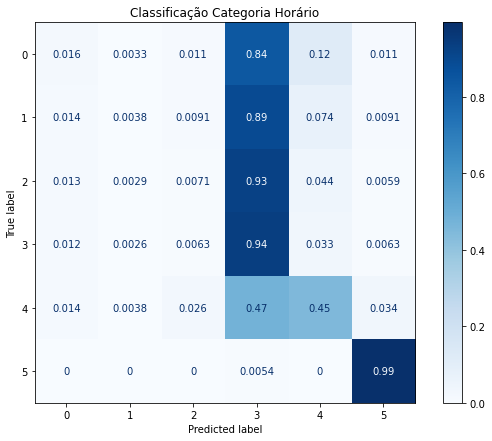

In [71]:
from sklearn.metrics import plot_confusion_matrix

# Matriz de Confusao
disp = plot_confusion_matrix(classificador, 
                             X_test, 
                             y_test, 
                             display_labels=list(set(y)),
                             cmap=plt.cm.Blues,
                             normalize='true')

disp.ax_.set_title('Classificação Categoria Horário')

plt.show()

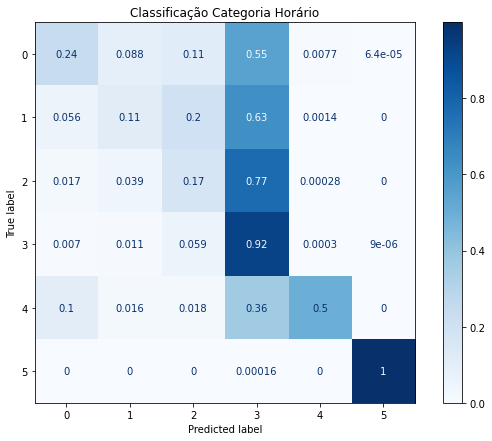

In [67]:
from sklearn.metrics import plot_confusion_matrix

# Matriz de Confusao
disp = plot_confusion_matrix(classificador, 
                             X_test2, 
                             y_test2, 
                             display_labels=list(set(y2)),
                             cmap=plt.cm.Blues,
                             normalize='true')

disp.ax_.set_title('Classificação Categoria Horário')

plt.show()

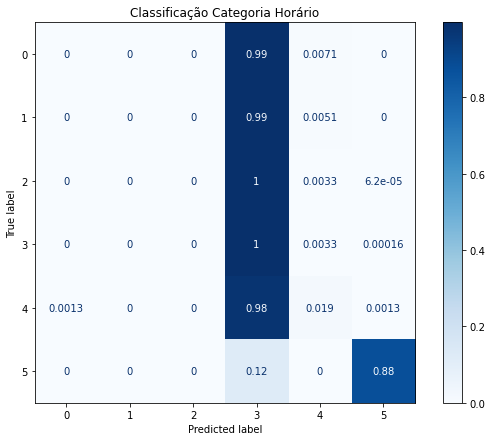

In [68]:
from sklearn.metrics import plot_confusion_matrix

# Matriz de Confusao
disp = plot_confusion_matrix(classificador_baseline, 
                             X_test, 
                             y_test, 
                             display_labels=list(set(y2)),
                             cmap=plt.cm.Blues,
                             normalize='true')

disp.ax_.set_title('Classificação Categoria Horário')

plt.show()

In [69]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt


precision_recall_fscore_support(y_test, Y_predict,
                                                beta=1.0, 
                                                labels=None, pos_label=1, average=None, 
                                                warn_for=('precision', 'recall', 'f-score'), 
                                                sample_weight=None, zero_division='warn')

(array([0.36410587, 0.21844055, 0.30709302, 0.81814977, 0.75692964,
        0.99962707]),
 array([0.22679228, 0.10579041, 0.16787265, 0.92447513, 0.44842105,
        1.        ]),
 array([0.27949453, 0.14254601, 0.21707893, 0.86806876, 0.56319408,
        0.9998135 ]),
 array([ 17408,  28150,  96740, 507078,   2375,  21444], dtype=int64))

In [ ]:
# Analisando as matrizes de confusão:

# Classe 0 = ATRASO_ALTO   
# Classe 1 = ATRASO_MEDIO   
# Classe 2 = ATRASO_MINIMO 
# Classe 3 = PONTUAL   
# Classe 4 = REEMBOLSAVEL
# Classe 5 = VOO_CANCELADO

# Na primeira (resultados do dataframe completo), vemos que o algoritmo acertou quase 100% da classe 3 e 100% da classe 5.
# A classe 4, que representa um atraso mais significativo, teve um acerto de 45%. 
# Porém nas classes 0, 1 e 2 mais de 80% de erro. Os vôos atrasados foram classificados como pontuais.

# Na segunda (resultados do dataframe sem 2020) o resultado é parecido em relação as classes 3, 4 e 5.
# Já nas classes 0, 1 e 2 a taxa de erro foi um pouco menor

# No terceiro (resultados do naive bayes) vimos que o algoritmo classificou todos os vôos atrasados como pontuais, 
# e acertou 88% dos cancelados (classe 5). 
# Com exceção dos acertos na classe 4, esses resultados foram semelhantes à primeira execução do RandomForest.

### 6) Conclusões **10%**

*Partindo das suas hipoteses e investigações, o que você consegue concluir? Suas hipoteses se concretizaram?*

***1) Concluo que deixar a parte de modelagem pra última hora não foi legal =S Os processamentos de tunning não finalizaram, provavelmente devido a quantidade de linhas no dataset ser muito grande.***

***2) Sem o tunning, não foi possível comprovar que o RandomForest pode apresentar resultados significativamente melhores do que o um Naive Bayes, as diferença não foi muito relevante***

***3) Comparando as matrizes de confusão dos resultados de 2018 a 2020 com os que não tem 2020, vimos que mesmo o ano de 2020 sendo bem atípico, não interferiu muito (pelo menos na execução sem tunning)***

***4) Talvez teria sido mais interessante utilizar um algmoritmo de regressão para tentar prever os minutos de atraso, ao invés da classe***